In [5]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [6]:
LUNG_CSV = './datasets/LungDisease.csv'
HOUSE_CSV = './datasets/house_sales.csv'

# 단순선형회귀

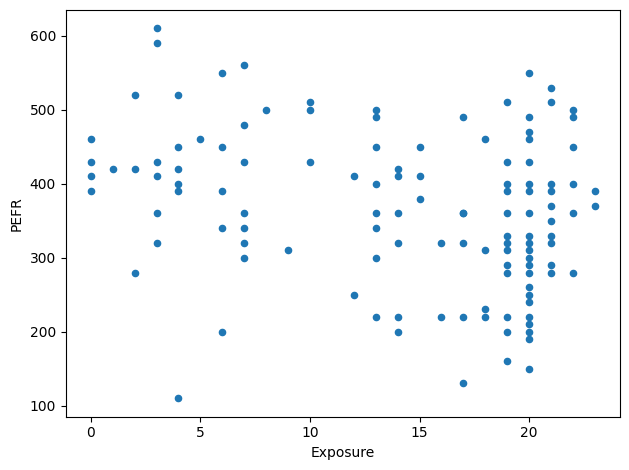

In [7]:
lung = pd.read_csv(LUNG_CSV)

lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

In [14]:
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept : {model.intercept_ : .3f}')
print(f'Coefficient Exposure : {model.coef_[0] :.3f}')

Intercept :  424.583
Coefficient Exposure : -4.185


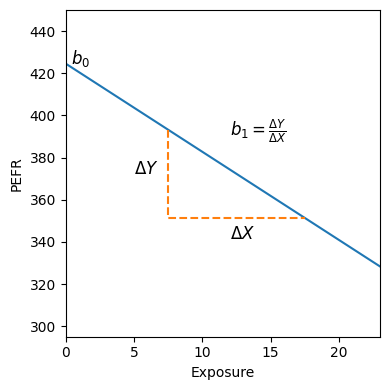

In [16]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict(pd.DataFrame({'Exposure': [0, 23]})))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = pd.DataFrame({'Exposure': [7.5,17.5]})
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

In [17]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

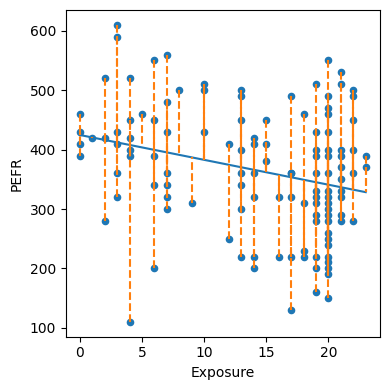

In [18]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

# 다중선형회귀

In [19]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [20]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

LinearRegression()

In [24]:
print(f'Intercept : {house_lm.intercept_:.3f}')
print('Coefficients')
for name, coef in zip(predictors, house_lm.coef_):
    print(f'{name} : {coef}')

Intercept : -521871.368
Coefficients
SqFtTotLiving : 228.83060360240734
SqFtLot : -0.06046682065304124
Bathrooms : -19442.84039832112
Bedrooms : -47769.95518521436
BldgGrade : 106106.96307898109


In [27]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE : {RMSE:.2f}')
print(f'r2 : {r2 :.4f}')

RMSE : 261220.20
r2 : 0.5406


In [35]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Sat, 19 Aug 2023   Prob (F-statistic):               0.00
Time:                        14:16:25   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694      0.000     221.189     236.472
SqFtLot          -0.0605      0.061     -0.988      0.323      -0.180       0.059
Bathrooms     -1.944e+04   3625.388     -5.363      0.000   -2.65e+04   -1.23e+04
Bedrooms      -4.777e+04   2489.732    -19.187      0.000   -5.27e+04   -4.29e+04
BldgGrade      1.061e+05   2396.445     44.277      0.000    1.01e+05    1.11e+05
const         -5.219e+05   1.57e+04    -33.342      0.000   -5.53e+05   -4.91e+05
==============================================================================
Omnibus:                    29676.557   Durbin-Watson:                   1.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19390738.346
Skew:                           6.889   Prob(JB):                         0.00
Kurtosis:                     145.559   Cond. No.                     2.86e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Sat, 19 Aug 2023   Prob (F-statistic):               0.00
Time:                        18:59:42   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving                198.6364      4.234     46.920      0.000     190.338     206.934
SqFtLot                        0.0771      0.058      1.330      0.184      -0.037       0.191
Bathrooms                   4.286e+04   3808.114     11.255      0.000    3.54e+04    5.03e+04
Bedrooms                   -5.187e+04   2396.904    -21.638      0.000   -5.66e+04   -4.72e+04
BldgGrade                   1.373e+05   2441.242     56.228      0.000    1.32e+05    1.42e+05
NbrLivingUnits              5723.8438   1.76e+04      0.326      0.744   -2.87e+04    4.01e+04
SqFtFinBasement                7.0611      4.627      1.526      0.127      -2.009      16.131
YrBuilt                    -3574.2210     77.228    -46.282      0.000   -3725.593   -3422.849
YrRenovated                   -2.5311      3.924     -0.645      0.519     -10.222       5.160
NewConstruction            -2489.1122   5936.692     -0.419      0.675   -1.41e+04    9147.211
PropertyType_Single Family  2.997e+04   2.61e+04      1.149      0.251   -2.12e+04    8.11e+04
PropertyType_Townhouse      9.286e+04    2.7e+04      3.438      0.001    3.99e+04    1.46e+05
const                       6.182e+06   1.55e+05     39.902      0.000    5.88e+06    6.49e+06
==============================================================================
Omnibus:                    31006.128   Durbin-Watson:                   1.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26251977.078
Skew:                           7.427   Prob(JB):                         0.00
Kurtosis:                     168.984   Cond. No.                     2.98e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
y = house[outcome]

def train_model(variable):
    if len(variable) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variable], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, 
                                               train_model, 
                                               score_model,
                                               verbose=True)
print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.2775530420157
 BldgGrade: 137159.56022620026
 YrBuilt: -3565.4249392493302
 Bedrooms: -51947.38367361384
 Bathrooms: 42396.16452771885
 PropertyType_Townhouse: 84479.16203300121
 SqFtFinBasement: 7.046974967572117
 PropertyType_Single Family: 22912.05518701784


In [40]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))
house['Weight'] = house.Year - 2005

In [41]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)

pd.concat([
    pd.DataFrame({
        'predictor': predictors,
        'house_lm': house_lm.coef_,
        'house_wt': house_wt.coef_,    
    }),
    pd.DataFrame({
        'predictor': ['intercept'],
        'house_lm': house_lm.intercept_,
        'house_wt': house_wt.intercept_,    
    })
])

predictor       house_lm       house_wt
0  SqFtTotLiving     228.830604     245.024089
1        SqFtLot      -0.060467      -0.292415
2      Bathrooms  -19442.840398  -26085.970109
3       Bedrooms  -47769.955185  -53608.876436
4      BldgGrade  106106.963079  115242.434726
0      intercept -521871.368188 -584189.329446

# 회귀에서의 요인변수

In [42]:
house.PropertyType.value_counts()

Single Family    20720
Townhouse         1710
Multiplex          257
Name: PropertyType, dtype: int64

In [44]:
pd.get_dummies(house['PropertyType'], drop_first=True).head(3)

Single Family  Townhouse
1              0          0
2              1          0
3              1          0

In [46]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.37362892503768
 SqFtLot: -0.07036798136812013
 Bathrooms: -15979.013473415245
 Bedrooms: -50889.73218483017
 BldgGrade: 109416.30516146199
 PropertyType_Single Family: -84678.21629549243
 PropertyType_Townhouse: -115121.97921609167


In [52]:
pd.DataFrame(house['ZipCode'].value_counts()).T

98038  98103  98042  98115  98117  98052  98034  98033  98059  98074  \
ZipCode    788    671    641    620    619    614    575    517    513    502   

         ...  98051  98024  98354  98050  98057  98288  98224  98068  98113  \
ZipCode  ...     32     31      9      7      4      4      3      1      1   

         98043  
ZipCode      1  

[1 rows x 80 columns]

In [62]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

LinearRegression()

array([ 424555.81419413, 1135307.41308934,  571696.27428408, ...,
        148421.0806143 ,  346082.70383261,  228913.37004649])

In [65]:
house[outcome] - house_lm.predict(house[predictors])

1       -123750.814194
2        -59145.413089
3        190108.725716
4       -198788.774412
5        -91774.996129
             ...      
27057     61921.802132
27058    140828.931399
27061     72322.919386
27062     -3875.703833
27063    246575.629954
Name: AdjSalePrice, Length: 22687, dtype: float64

In [87]:
house = pd.read_csv(HOUSE_CSV, sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

0    16
1    16
2    16
3    16
4    16
Name: ZipGroup, dtype: int64


In [88]:
zip_groups

ZipCode  count  median_residual  cum_count  ZipGroup
36    98057      4   -537321.644462          4         0
27    98043      1   -307661.343614          5         0
46    98092    289   -193569.183599        294         0
23    98038    788   -150066.477035       1082         0
31    98051     32   -142352.869593       1114         0
..      ...    ...              ...        ...       ...
60    98119    260    174462.549290      21746         4
54    98112    357    232788.487256      22103         4
25    98040    244    254004.002463      22347         4
3     98004    293    383596.028729      22640         4
24    98039     47    740960.478872      22687         4

[80 rows x 5 columns]

# 회귀방정식 해석

In [89]:
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.2775530420157
 BldgGrade: 137159.56022620026
 YrBuilt: -3565.4249392493302
 Bedrooms: -51947.38367361384
 Bathrooms: 42396.16452771885
 PropertyType_Townhouse: 84479.16203300121
 SqFtFinBasement: 7.046974967572117
 PropertyType_Single Family: 22912.05518701784


<Axes: >

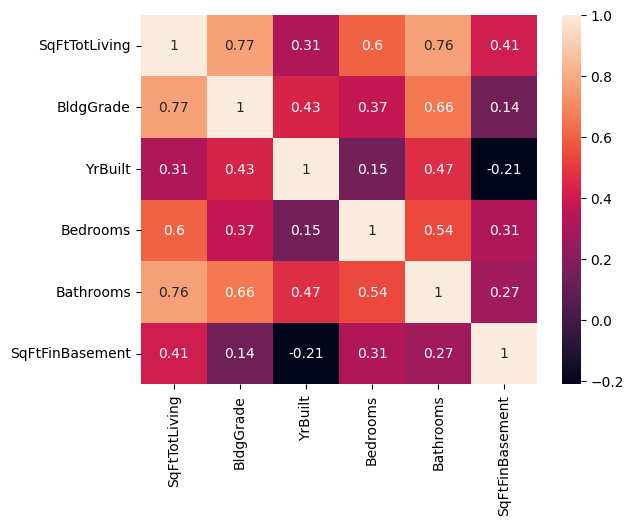

In [99]:
import seaborn as sns

sns.heatmap(house[['SqFtTotLiving',
 'BldgGrade',
 'YrBuilt',
 'Bedrooms',
 'Bathrooms',
 'SqFtFinBasement']].corr(), annot=True)

In [90]:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])


print(f'Intercept: {reduced_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

Intercept: 4913973.344
Coefficients:
 Bedrooms: 27150.537230215294
 BldgGrade: 248997.79366213747
 YrBuilt: -3211.7448621550966
 PropertyType_Single Family: -19898.49534050217
 PropertyType_Townhouse: -47355.43687334463


In [110]:
house = pd.read_csv(HOUSE_CSV, sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups = zip_groups[['ZipCode', 'ZipGroup']]

In [112]:
house = house.merge(zip_groups, on = 'ZipCode', how='left')

In [114]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -713359.153
Coefficients:
 SqFtTotLiving: 209.50217718293604
 SqFtLot: 0.3999830485689585
 Bathrooms: 7856.429233772692
 Bedrooms: -42046.2530798743
 BldgGrade: 102320.43850139705
 ZipGroup: 81491.99367872122
 PropertyType_Single Family: 13710.897822098492
 PropertyType_Townhouse: -86594.74924610414


In [115]:
model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + ' +
     'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     5097.
Date:                Sun, 20 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:26:00   Log-Likelihood:            -3.1144e+05
No. Observations:               22687   AIC:                         6.229e+05
Df Residuals:                   22677   BIC:                         6.230e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

# 회귀진단

In [116]:
house_98105 = house.loc[house['ZipCode'] == 98105, ]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()

In [118]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal
sresiduals.idxmin(), sresiduals.min()

(20428, -4.326731804078564)

In [121]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 20428, dtype: object


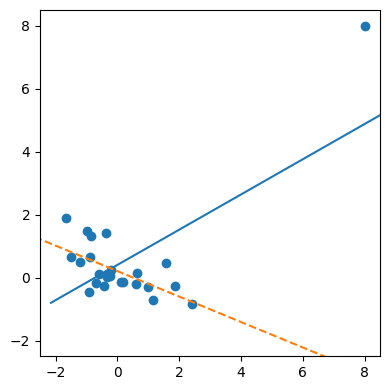

In [122]:
%matplotlib inline
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

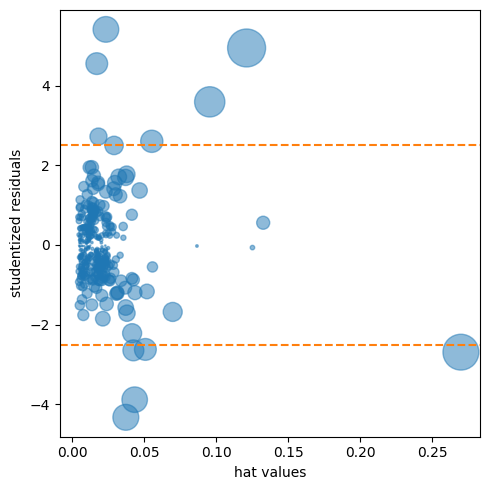

In [123]:
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()

In [124]:
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

Original  Influential removed
SqFtTotLiving     209.602346           230.052569
SqFtLot            38.933315            33.141600
Bathrooms        2282.264145        -16131.879785
Bedrooms       -26320.268796        -22887.865318
BldgGrade      130000.099737        114870.559737
const         -772549.862447       -647137.096716

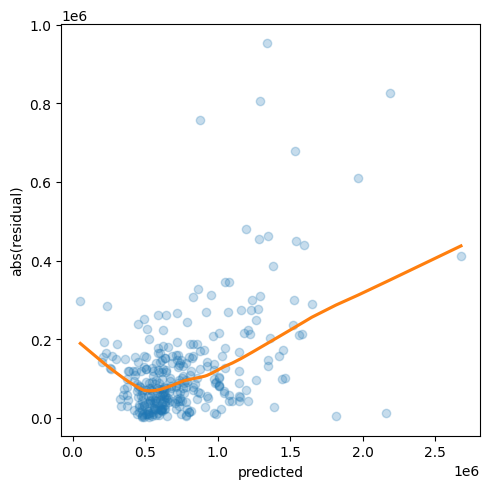

In [125]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

plt.tight_layout()
plt.show()

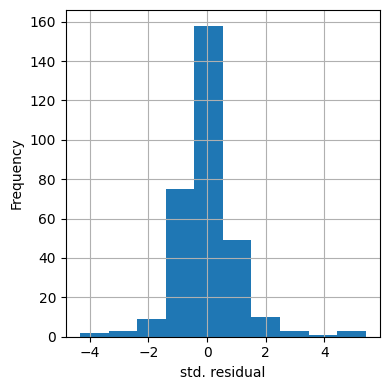

In [126]:
fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')


plt.tight_layout()
plt.show()

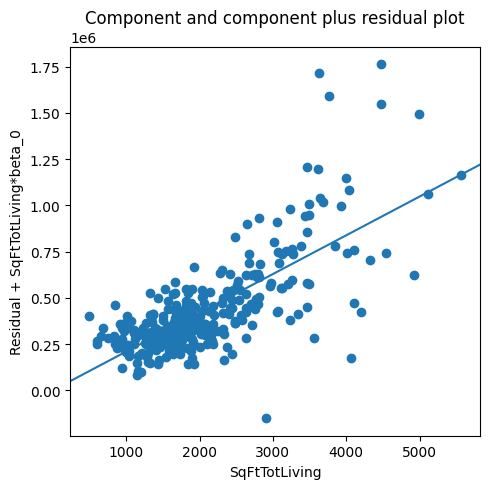

In [127]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)

plt.tight_layout()
plt.show()

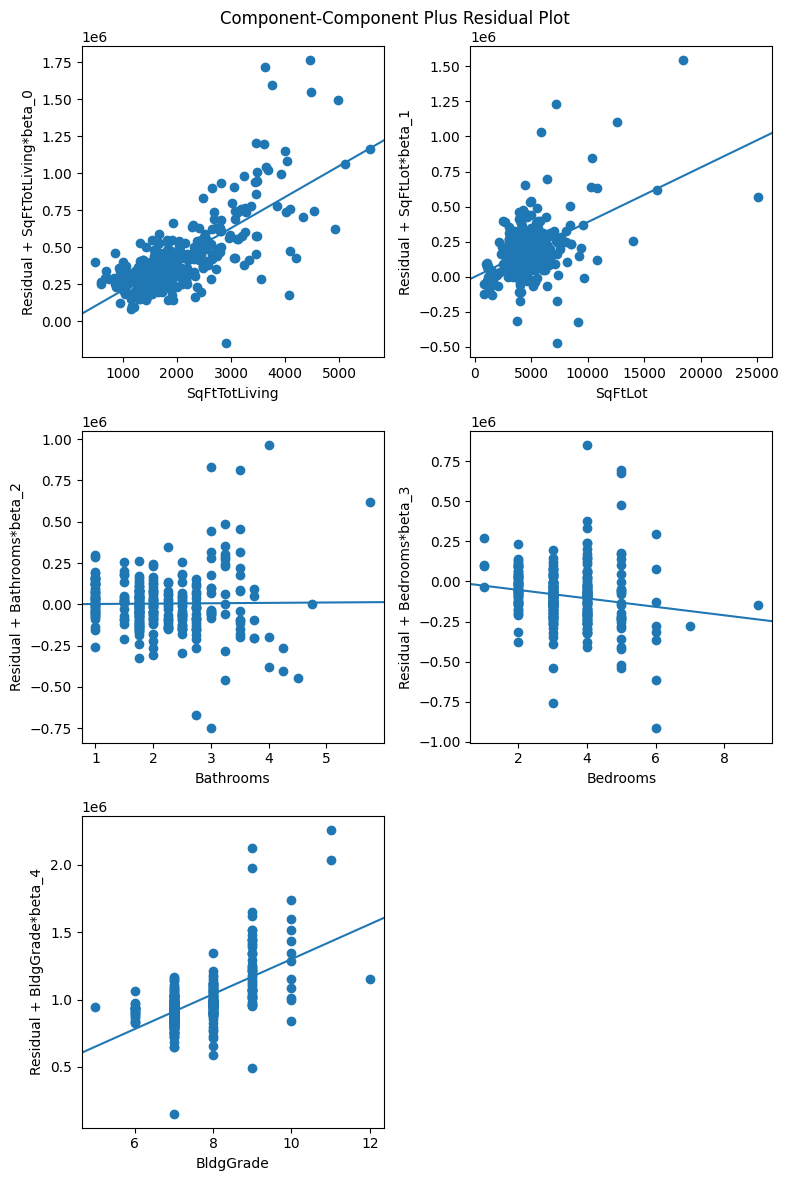

In [128]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

# 다항회귀와 스플라인 회귀

In [129]:
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Sun, 20 Aug 2023   Prob (F-statistic):          9.95e-106
Time:                        21:07:20   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

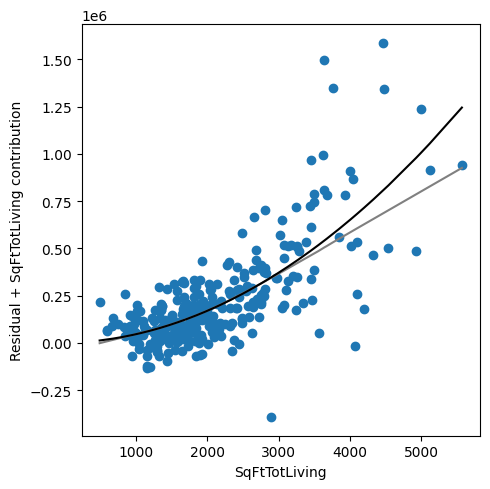

0.0387912816823115


In [130]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

In [131]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Sun, 20 Aug 2023   Prob (F-statistic):          7.10e-104
Time:                        21:10:35   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


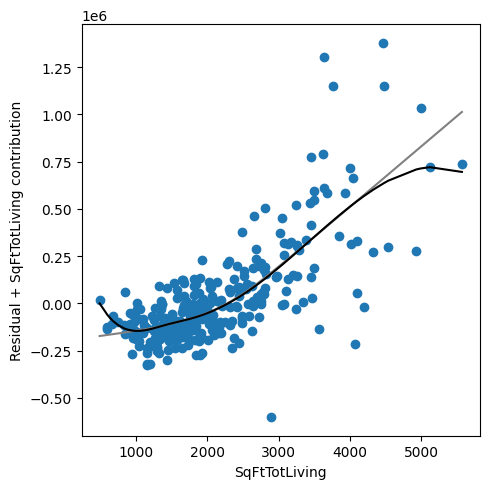

In [132]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()

In [133]:
from statsmodels.gam.api import GLMGam, BSplines

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

x_spline = house_98105[predictors]
bs = BSplines(x_spline, df=[10] + [3] * 4, degree=[3] + [2] * 4)
# penalization weight
alpha = np.array([0] * 5)

formula = ('AdjSalePrice ~ SqFtTotLiving + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')

gam_sm = GLMGam.from_formula(formula, data=house_98105, smoother=bs, alpha=alpha)
res_sm = gam_sm.fit()
print(res_sm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           AdjSalePrice   No. Observations:                  313
Model:                         GLMGam   Df Residuals:                      295
Model Family:                Gaussian   Df Model:                        17.00
Link Function:               identity   Scale:                      2.7471e+10
Method:                         PIRLS   Log-Likelihood:                -4196.6
Date:                Sun, 20 Aug 2023   Deviance:                   8.1039e+12
Time:                        21:12:06   Pearson chi2:                 8.10e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9901
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.481e+05   1.18e+05  